# Stepped-wedge data gen sandbox

IE each row represents an individual but treatment assignent (the crossover point) is clustered at the zip code level. The crossover point of each zip code is randomly assigned (either period 2 or period 3).

In [10]:
library(tidyverse)
library(estimatr)
library(broom)
library(lme4)

ss_per_period <- 50000
num_periods <- 4
num_clusters <- 60
num_per_cluster <- ss_per_period/num_clusters

In [28]:
# STUDY DESIGN 
assignment_func <- NULL 
effect_sizes <- c(0.03,0.05,0.10,0.15)

ss_per_period <- seq(10, 3000, by = 50)
num_periods <- 4
num_clusters <- 60
num_per_cluster <- ss_per_period/num_clusters
p <- expand.grid(list(es=effect_sizes,ss_per_period=ss_per_period,num_per_cluster=as.integer(ss_per_period/num_clusters)+1))
nrow(p)

[1] 14400

In [11]:

tib <- tibble(
  index=1:ss_per_period,
  # We can assign groups from 1 to 10, a categorical variable, using sample()
  # if we don't specify prob it defaults to equal probabilities
  zip = sample(1:num_clusters, ss_per_period, replace = TRUE)
  ) %>%
    mutate(  
      svi = zip*1.5) %>%
  crossing(.,data.frame(period=1:num_periods)) %>%
  select(period,zip,svi)
  
head(tib)

period,zip,svi
<int>,<int>,<dbl>
1,6,9.0
2,6,9.0
3,6,9.0
4,6,9.0
1,41,61.5
2,41,61.5


In [12]:
group_data <- tib %>%
    group_by(zip) %>%
    summarize(mean_svi = mean(svi)) %>%
    # UPDATE HERE IF YOU WANT TO CHANGE TREATMENT ASSIGNMENT MECHANISM (IE A FUNCTION OF SVI)
    mutate(crossover = sample(c(2,3),
        nrow(.),
        replace=TRUE)) %>%
    select(zip,crossover)
    
head(group_data)

zip,crossover
<int>,<dbl>
1,3
2,3
3,3
4,3
5,3
6,3


In [19]:
tib <- tib %>%
    left_join(group_data) %>%
    mutate(treatment = as.integer(crossover > period)) %>%
    # UPDATE HERE IF YOU WANT TO ADD ZIP CODE LEVEL EFFECTS
    mutate(missing_field_rate = 0.15*treatment+(rbinom(nrow(.),100,0.45)/100) + rnorm(nrow(.), mean = 0, sd = (zip/100)),
        num_secondary_tests = 0.03*treatment + rpois(nrow(.), 2) + rnorm(nrow(.), mean = 0, sd =(zip/100)))

head(tib)

Joining, by = c("zip", "crossover")



period,zip,svi,crossover,treatment,missing_field_rate,num_secondary_tests
<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,6,9.0,3,1,0.5637598,4.0334808
2,6,9.0,3,1,0.6264997,-0.0159478
3,6,9.0,3,0,0.4793086,3.0521390
4,6,9.0,3,0,0.4384983,1.9281895
1,41,61.5,2,1,1.0879215,-0.2023636
2,41,61.5,2,0,-0.1784263,2.0338477


In [14]:
nrow(tib)/ss_per_period
nrow(tib)/num_periods
nrow(tib)/(num_periods*num_clusters) == num_per_cluster

[1] 4

[1] 50000

[1] TRUE

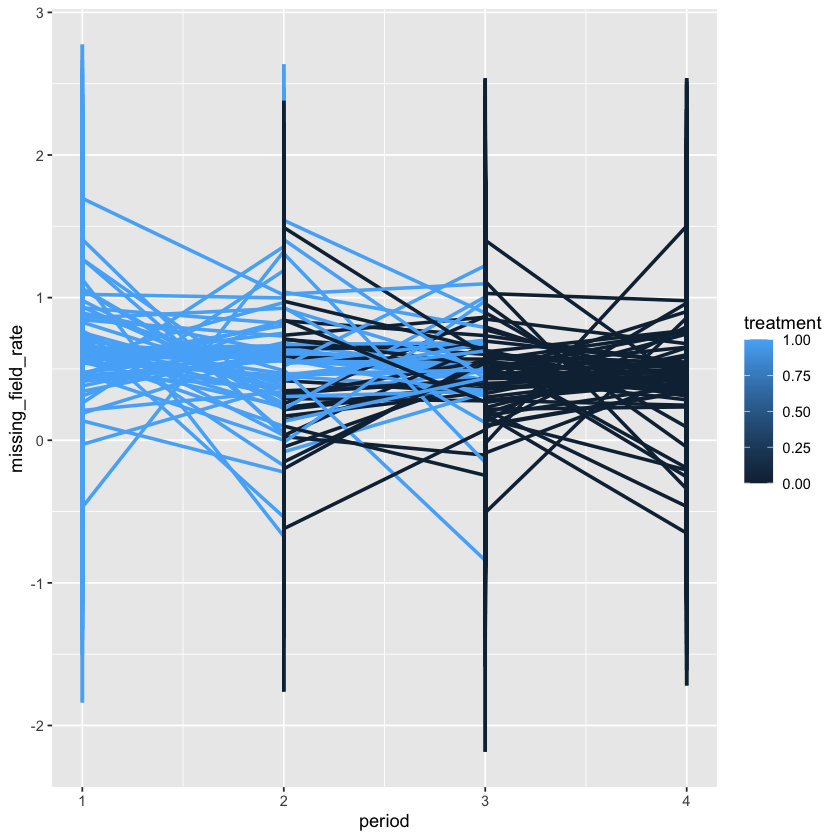

In [21]:
ggplot(tib,
     aes(x = period, y = missing_field_rate,group=zip,color=treatment)) +
     geom_line(size=1)


In [18]:
m <- lm_robust(missing_field_rate ~ period + zip + treatment,data=tib)
summary(m)


Call:
lm_robust(formula = missing_field_rate ~ period + zip + treatment, 
    data = tib)

Standard error type:  HC2 

Coefficients:
              Estimate Std. Error  t value  Pr(>|t|)  CI Lower  CI Upper    DF
(Intercept)  0.4444852  0.0407640 10.90385 1.125e-27  0.364589 0.5243818 2e+05
period       0.0002348  0.0119554  0.01964 9.843e-01 -0.023197 0.0236671 2e+05
zip         -0.0001973  0.0004959 -0.39780 6.908e-01 -0.001169 0.0007747 2e+05
treatment    0.1703291  0.0274793  6.19844 5.714e-10  0.116470 0.2241879 2e+05

Multiple R-squared:  0.0005574 ,	Adjusted R-squared:  0.0005424 
F-statistic: 37.19 on 3 and 199996 DF,  p-value: < 2.2e-16

In [23]:
m <- lmer(missing_field_rate ~ period + (1|zip) + treatment,data=tib)
summary(m)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: missing_field_rate ~ period + (1 | zip) + treatment
   Data: tib

REML criterion at convergence: 151265.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.4608 -0.4630  0.0002  0.4641  6.1583 

Random effects:
 Groups   Name        Variance Std.Dev.
 zip      (Intercept) 0.0000   0.0000  
 Residual             0.1247   0.3532  
Number of obs: 200000, groups:  zip, 60

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.447336   0.004026 111.103
period      0.001092   0.001212   0.901
treatment   0.151559   0.002787  54.387

Correlation of Fixed Effects:
          (Intr) period
period    -0.968       
treatment -0.877  0.813
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular
